# Azcorra 2023 demo

This tutorial demonstrates how to access an NWB file from the [DANDI:001038](https://dandiarchive.org/dandiset/001038/draft) dandiset using `pynwb` and `dandi`.

This session contains fiber photometry recordings from head-fixed mice running on a treadmill while receiving rewards and aversive air puffs in order to analyze differences or similarities in functional responses of different subtypes of striatonigral dopamine neurons.

Contents:

- [Streaming an NWB file](#stream-nwb)
- [Access Subject Metadata](#access-subject-metadata)
- [Access raw fiber photometry data](#access-fiber-photometry)
- [Access processed fiber photometry data](#access-processed-fiber-photometry)
- [Access behavior](#access-behavior)
- [View NWB file](#view-nwb)



# Streaming an NWB file <a id="stream-nwb"></a>

This section demonstrates how to access the files on the [DANDI Archive](https://dandiarchive.org) without downloading them. Based on the [Streaming NWB files](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html) tutorial from [PyNWB](https://pynwb.readthedocs.io/en/stable/#).

An [NWBFile](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.NWBFile) represents a single session of an experiment. Each NWBFile must have a `session description`, `identifier`, and `session start time`.

The `dandi.dandiapi.DandiAPIClient` can be used to get the S3 URL of the NWB file stored in the DANDI Archive.

In [ ]:
from dandi.dandiapi import DandiAPIClient

client = DandiAPIClient.for_dandi_instance("dandi")

dandiset_id = "001038"
file_path = "sub-VGlut-A997/sub-VGlut-A997_ses-20200205-0001.nwb"

with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(file_path)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

We will use `remfile` for streaming the file. You can read more about `remfile` at [this tutorial section](https://pynwb.readthedocs.io/en/stable/tutorials/advanced_io/streaming.html#method-3-remfile).

In [ ]:
import h5py
from pynwb import NWBHDF5IO
import remfile

# We stream the file using remfile and open it with h5py and pynwb
file = remfile.File(s3_url)
h5_file = h5py.File(file, "r")

io = NWBHDF5IO(file=h5_file, load_namespaces=True)
nwbfile = io.read()
nwbfile

# Access Subject Metadata <a id="access-subject-metadata"></a>

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWB file.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.


In [3]:
nwbfile.subject

subject pynwb.file.Subject at 0x6075774032
Fields:
  age: P8W/P16W
  age__reference: birth
  genotype: Vglut2-IRES-Cre/Th-Flpo (RRID, IMSR_JAX:016963)
  sex: F
  species: Mus musculus
  strain: C57BL6
  subject_id: VGlut-A997

# Access fiber photometry data <a id="access-fiber-photometry"></a>

This section demonstrates how to access the fiber photometry data in the NWBfile.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## Picoscope signals


The signals collected at 4000 Hz from the PicoScope acquisition system are added to `nwbfile.acquisition` and are stored in [pynwb.base.TimeSeries](https://pynwb.readthedocs.io/en/stable/pynwb.base.html#pynwb.base.TimeSeries) objects. These signals include the fluorescence traces from one or two optical fibers, velocity and may additionally include the stimulus signals (light, air puff, reward delivery). 

The fluorescence traces from the optical fiber(s) can be accessed as `nwbfile.acquisition["Fluorescence"]`. 

The velocity from the rotary encoder can be accessed as `nwbfile.acquisition["Velocity"]`.



In [6]:
fluorescence_picoscope = nwbfile.acquisition["Fluorescence"]
fluorescence_picoscope

Fluorescence pynwb.base.TimeSeries at 0x6078648528
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (6761014, 2), type "<f4">
  description: The fluorescence traces from one or two optical fibers during 405 nm and 470 nm illumination collected at 4000 Hz by Picoscope.
  offset: 0.0
  rate: 4000.2000543686745
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: Volts

In [5]:
velocity_picoscope = nwbfile.acquisition["Velocity"]
velocity_picoscope

Velocity pynwb.base.TimeSeries at 0x6079743120
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (6761014,), type "<f4">
  description: Velocity from rotary encoder collected at 4000 Hz by Picoscope.
  offset: 0.0
  rate: 4000.2000543686745
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: Volts

## Picoscope TTL signals

The 405 nm and 470 nm illumination onset times are stored in a `TtlsTable` object using [`ndx-events`](https://github.com/rly/ndx-events) and can be accessed as `nwbfile.acquisition["TtlsTable"]`. The id of events and the description of the TTL event can be accessed as `nwbfile.acquisition["TtlTypesTable"]`.



In [41]:
import pandas as pd

ttl_times = pd.merge(
    left=nwbfile.acquisition["TtlsTable"][:],
    right=nwbfile.acquisition["TtlTypesTable"][:],
    left_on="ttl_type",
    right_on="id",
)
ttl_times.head()

,timestamp,ttl_type,event_name,event_type_description,pulse_value,duration
0,0.001000,1,Ch470,The times when the 470 nm LED was on.,1,0.005
1,0.006000,0,Ch405,The times when the 405 nm LED was on.,0,0.005
2,0.010999,1,Ch470,The times when the 470 nm LED was on.,1,0.005
3,0.015999,0,Ch405,The times when the 405 nm LED was on.,0,0.005
4,0.020999,1,Ch470,The times when the 470 nm LED was on.,1,0.005


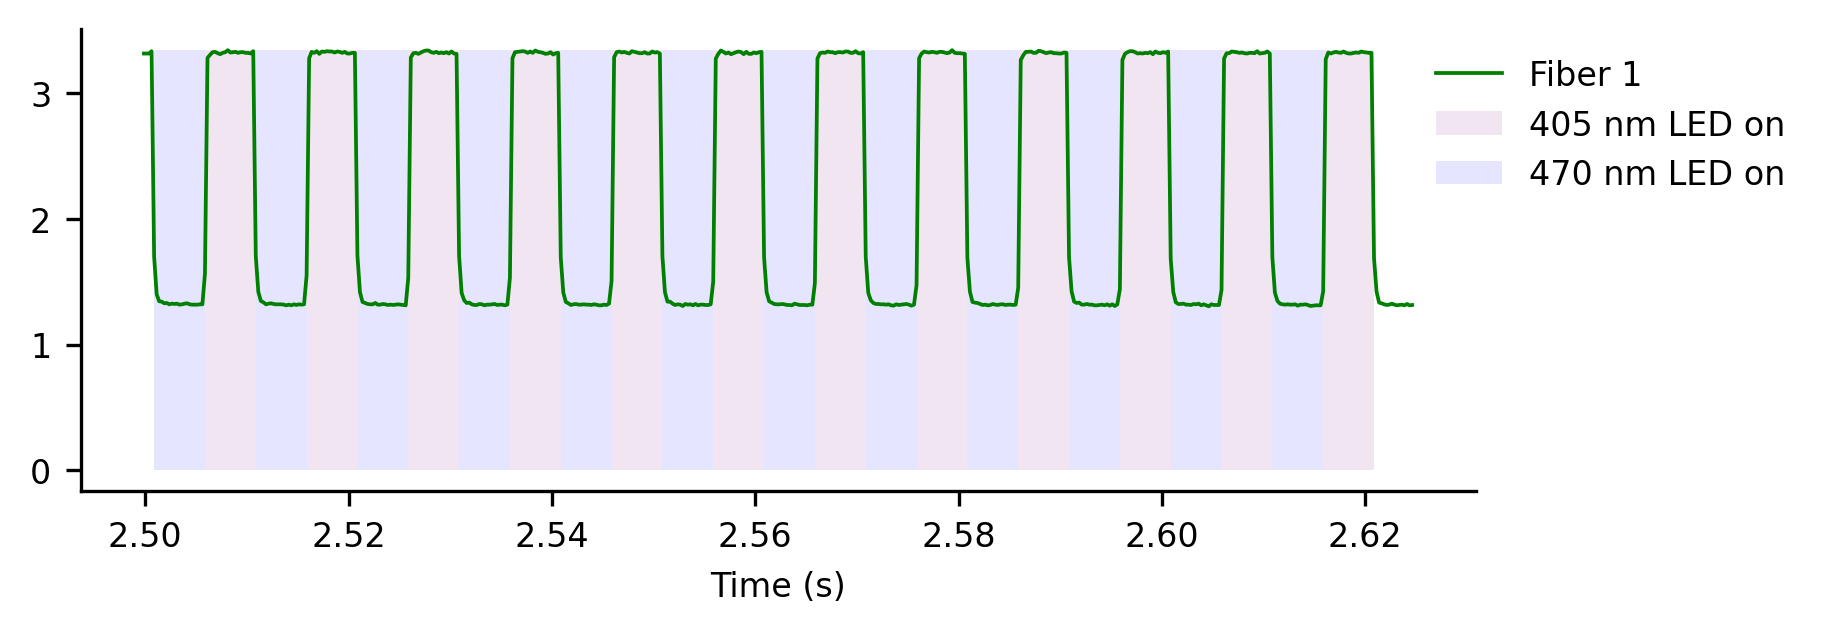

In [42]:
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = fluorescence_picoscope.data[10000:10500, 0]
timestamps = fluorescence_picoscope.get_timestamps()[10000:10500]

fig, ax = plt.subplots(figsize=(6, 2), dpi=300)
line_handle, = ax.plot(timestamps, data, color="green", linewidth=0.9, label="Fiber 1")

ttl_0 = ttl_times[ttl_times["ttl_type"] == 0]
violet_illumination_times = ttl_0[(ttl_0["timestamp"] > 2.5) & (ttl_0["timestamp"] <= 2.62)]
violet_handles = []
for illumination_onset in violet_illumination_times["timestamp"]:
    fill_end = illumination_onset + 0.005
    violet_handle = ax.fill_between(timestamps, max(data), where=(timestamps >= illumination_onset) & (timestamps <= fill_end), 
                                    color='purple', edgecolor='none', alpha=0.1, label="405 nm LED on")
    violet_handles.append(violet_handle)

ttl_1 = ttl_times[ttl_times["ttl_type"] == 1]
blue_illumination_times = ttl_1[(ttl_1["timestamp"] > 2.5) & (ttl_1["timestamp"] <= 2.62)]
blue_handles = []
for illumination_onset in blue_illumination_times["timestamp"]:
    fill_end = illumination_onset + 0.005
    blue_handle = ax.fill_between(timestamps, max(data), where=(timestamps >= illumination_onset) & (timestamps <= fill_end), 
                                  color='blue', edgecolor='none', alpha=0.1, label="470 nm LED on")
    blue_handles.append(blue_handle)

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create the legend with the appropriate handles
handles = [line_handle, violet_handles[0], blue_handles[0]]
labels = ["Fiber 1", "405 nm LED on", "470 nm LED on"]
ax.legend(handles, labels, frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})

ax.tick_params(axis='y', labelsize=8)
plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.show()


## Fiber photometry traces

The fluorescence signals from the Picoscope were separated due to 405 vs 470 nm illumination (405 nm is GCaMP's isosbestic point and thus serves as a movement control) and were re-binned from 4000 Hz to 100 Hz.

The fluorescence traces are added to `nwbfile.acquisition` and are stored in a `FiberPhotometryResponseSeries` object using [`ndx-fiber-photometry`](https://github.com/catalystneuro/ndx-fiber-photometry). 
The fluorescence data during 470 nm excitation can be accessed as `nwbfile.acquisition["FiberPhotometryResponseSeries"]`. The control signal can be accessed as `nwbfile.acquisition["FiberPhotometryResponseSeriesIsosbestic"]`.

In [43]:
fiber_photometry_response_series = nwbfile.acquisition["FiberPhotometryResponseSeries"]
fiber_photometry_response_series

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,fiber_depth_in_mm,baseline_fluorescence,normalized_fluorescence,recording_target_type,signal_to_noise_ratio,cross_correlation_with_acceleration,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,,,,,
0,SNc,GCaMP6f abc.Indicator at 0x13817080272\nFields:\n injection_coordinates_in_mm: [-3.25 1.55 -3.8 ]\n injection_location: SNc\n label: AAV-GCaMP6f\n,Fiber1 abc.OpticalFiber at 0x13821382928\nFields:\n core_diameter_in_um: 200.0\n description: The optical fiber used to record the GCaMP fluorescence from the SNc brain region.\n manufacturer: Doric\n model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF\n numerical_aperture: 0.57\n,"ExcitationSource470 abc.ExcitationSource at 0x13816578704\nFields:\n description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)\nwere coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.\nThen, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,\neach filtered with a corresponding filter.\n\n excitation_wavelength_in_nm: 470.0\n illumination_type: LED\n manufacturer: Thorlabs\n model: M70F3\n",PhotodetectorPMT abc.Photodetector at 0x13709448400\nFields:\n description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).\n detected_wavelength_in_nm: 520.0\n detector_type: PMT\n manufacturer: Hamamatsu Photonics\n model: H10770PA-40\n,DichroicMirror abc.DichroicMirror at 0x13821590608\nFields:\n cut_on_wavelength_in_nm: 505.0\n description: The dichroic mirror used to separate green fluorescence from the excitation light.\n manufacturer: Chroma Tech Corp\n model: T505lpxr\n transmission_band_in_nm: [505. 750.]\n,3.6,1.041767,0.686421,cell bodies in SNc,18.898114,0.067393,"[nan, nan, nan]",EmissionFilter abc.BandOpticalFilter at 0x13809080144\nFields:\n bandwidth_in_nm: 50.0\n center_wavelength_in_nm: 540.0\n description: The band-pass filter used to further filter the green fluorescence after it was separated from the excitation light by a dichroic mirror.\n filter_type: Bandpass\n manufacturer: Semrock\n model: FF01-540/50-25\n,OpticalFilter470 abc.BandOpticalFilter at 0x13707100624\nFields:\n bandwidth_in_nm: 30.0\n center_wavelength_in_nm: 472.0\n description: The band-pass filter used to isolate the 470 nm excitation light.\n filter_type: Bandpass\n manufacturer: Semrock\n model: FF02-472/30-25\n
1,TS,GCaMP6f abc.Indicator at 0x13817080272\nFields:\n injection_coordinates_in_mm: [-3.25 1.55 -3.8 ]\n injection_location: SNc\n label: AAV-GCaMP6f\n,Fiber2 abc.OpticalFiber at 0x13790782352\nFields:\n core_diameter_in_um: 200.0\n description: The second optical fiber used to record the GCaMP fluorescence from the TS brain region.\n manufacturer: Doric\n model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF\n numerical_aperture: 0.57\n,"ExcitationSource470 abc.ExcitationSource at 0x13816578704\nFields:\n description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)\nwere coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.\nThen, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,\neach filtered with a corresponding filter.\n\n excitation_wavelength_in_nm: 470.0\n illumination_type: LED\n manufacturer: Thorlabs\n model: M70F3\n",PhotodetectorPMT abc.Photodetector at 0x13709448400\nFields:\n description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).\n detected_wavelength_in_nm: 520.0\n detector_type: PMT\n manufacturer: Hamamatsu Photonics\n model: H10770PA-40\n,DichroicMirror abc.DichroicMirror at 0x13821590608\nFields:\n cut_on_wavelength_in_nm: 505.0\n description: The dichroic mirror used to separate green fluorescence from the excitation light.\n manufacturer: Chr

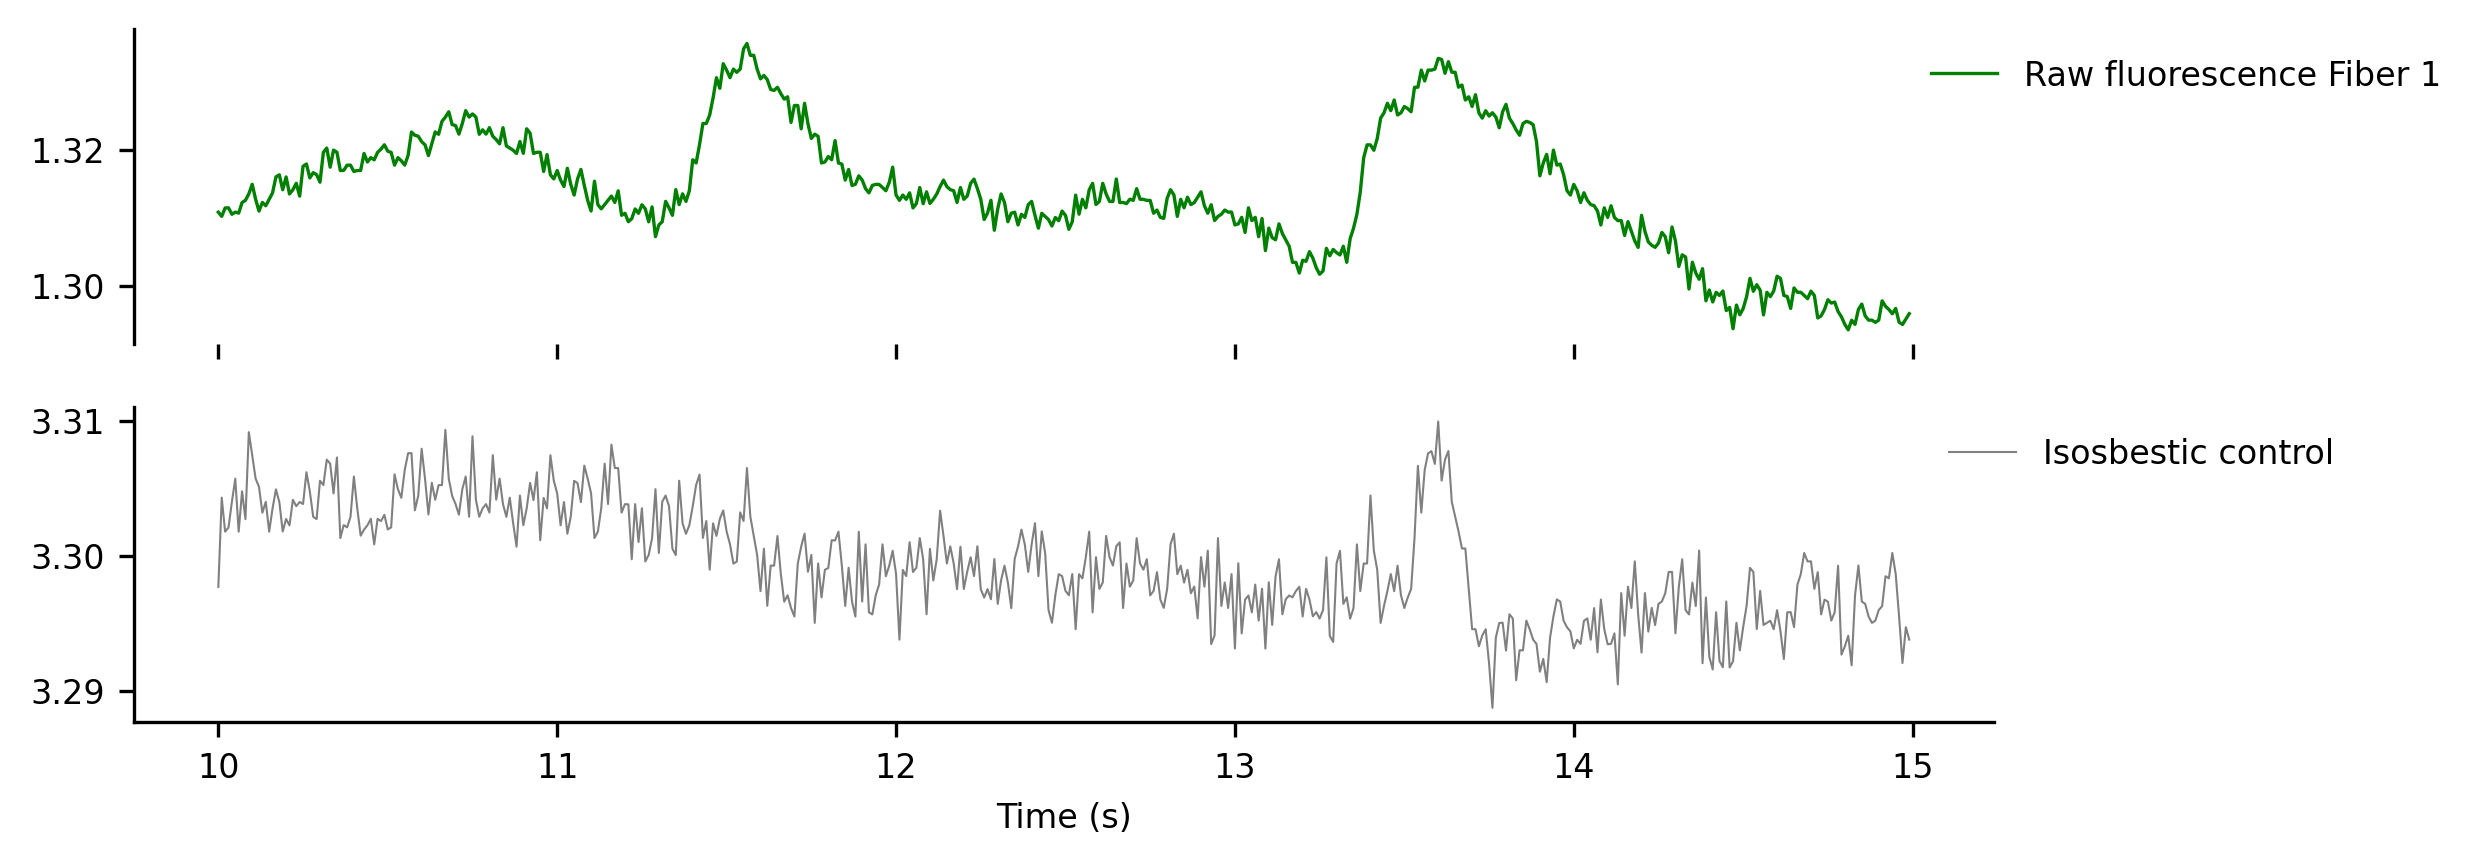

In [44]:
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = fiber_photometry_response_series.data[1000:1500, 0]
timestamps = fiber_photometry_response_series.get_timestamps()[1000:1500]

control_signal = nwbfile.acquisition["FiberPhotometryResponseSeriesIsosbestic"]
control_data = control_signal.data[1000:1500, 0]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), dpi=300, sharex=True)

# Plot data
ax[0].plot(timestamps, data, color="green", linewidth=0.8, label='Data')

# Plot control data with offset
ax[1].plot(timestamps, control_data, color="grey", linewidth=0.5, label='Control Data (shifted)')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].legend(["Raw fluorescence Fiber 1"], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})
ax[1].legend(["Isosbestic control"], frameon=False, bbox_to_anchor=(.96, 1), loc='upper left', prop={'size': 8})
ax[1].tick_params(axis='y', labelsize=8)
ax[0].tick_params(axis='y', labelsize=8)


plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.show()


## Fiber photometry metadata

The fiber photometry metadata includes the type of indicator(s), optical fiber(s), excitation source(s), photodector(s), dichroic mirror(s), and optical filter(s) that were used to construct a single fluorescence signal.

The metadata is stored in a `FiberPhotometryTable` object using [`ndx-fiber-photometry`](https://github.com/catalystneuro/ndx-fiber-photometry) and is added to `nwbfile.lab_meta_data`. It can be accessed as `nwbfile.lab_meta_data["FiberPhotometry"].fiber_photometry_table`.

In [45]:
nwbfile.lab_meta_data["FiberPhotometry"].fiber_photometry_table[:]

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,fiber_depth_in_mm,baseline_fluorescence,normalized_fluorescence,recording_target_type,signal_to_noise_ratio,cross_correlation_with_acceleration,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,,,,,
0,SNc,GCaMP6f abc.Indicator at 0x13817080272\nFields...,Fiber1 abc.OpticalFiber at 0x13821382928\nFiel...,ExcitationSource470 abc.ExcitationSource at 0x...,PhotodetectorPMT abc.Photodetector at 0x137094...,DichroicMirror abc.DichroicMirror at 0x1382159...,3.6,1.041767,0.686421,cell bodies in SNc,18.898114,0.067393,"[nan, nan, nan]",EmissionFilter abc.BandOpticalFilter at 0x1380...,OpticalFilter470 abc.BandOpticalFilter at 0x13...
1,TS,GCaMP6f abc.Indicator at 0x13817080272\nFields...,Fiber2 abc.OpticalFiber at 0x13790782352\nFiel...,ExcitationSource470 abc.ExcitationSource at 0x...,PhotodetectorPMT abc.Photodetector at 0x137094...,DichroicMirror abc.DichroicMirror at 0x1382159...,1.0,1.050157,0.053596,axons in striatum,0.000000,0.014802,"[3.0748749730962577, -0.58, 2.1599445426572172]",EmissionFilter abc.BandOpticalFilter at 0x1380...,OpticalFilter470 abc.BandOpticalFilter at 0x13...
2,SNc,GCaMP6f abc.Indicator at 0x13817080272\nFields...,Fiber1 abc.OpticalFiber at 0x13821382928\nFiel...,ExcitationSource405 abc.ExcitationSource at 0x...,PhotodetectorPMT abc.Photodetector at 0x137094...,DichroicMirror abc.DichroicMirror at 0x1382159...,3.6,1.041767,0.686421,cell bodies in SNc,18.898114,0.067393,"[nan, nan, nan]",EmissionFilter abc.BandOpticalFilter at 0x1380...,OpticalFilter405 abc.BandOpticalFilter at 0x13...
3,TS,GCaMP6f abc.Indicator at 0x13817080272\nFields...,Fiber2 abc.OpticalFiber at 0x13790782352\nFiel...,ExcitationSource405 abc.ExcitationSource at 0x...,PhotodetectorPMT abc.Photodetector at 0x137094...,DichroicMirror abc.DichroicMirror at 0x1382159...,1.0,1.050157,0.053596,axons in striatum,0.000000,0.014802,"[3.0748749730962577, -0.58, 2.1599445426572172]",EmissionFilter abc.BandOpticalFilter at 0x1380...,OpticalFilter405 abc.BandOpticalFilter at 0x13...


The `fiber_photometry_table_region` attribute in the `FiberPhotometryResponseSeries` object references row(s) of this table:

In [46]:
fiber_photometry_table_region = nwbfile.acquisition["FiberPhotometryResponseSeries"].fiber_photometry_table_region[:]
fiber_photometry_table_region

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,fiber_depth_in_mm,baseline_fluorescence,normalized_fluorescence,recording_target_type,signal_to_noise_ratio,cross_correlation_with_acceleration,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,,,,,
0,SNc,GCaMP6f abc.Indicator at 0x13817080272\nFields...,Fiber1 abc.OpticalFiber at 0x13821382928\nFiel...,ExcitationSource470 abc.ExcitationSource at 0x...,PhotodetectorPMT abc.Photodetector at 0x137094...,DichroicMirror abc.DichroicMirror at 0x1382159...,3.6,1.041767,0.686421,cell bodies in SNc,18.898114,0.067393,"[nan, nan, nan]",EmissionFilter abc.BandOpticalFilter at 0x1380...,OpticalFilter470 abc.BandOpticalFilter at 0x13...
1,TS,GCaMP6f abc.Indicator at 0x13817080272\nFields...,Fiber2 abc.OpticalFiber at 0x13790782352\nFiel...,ExcitationSource470 abc.ExcitationSource at 0x...,PhotodetectorPMT abc.Photodetector at 0x137094...,DichroicMirror abc.DichroicMirror at 0x1382159...,1.0,1.050157,0.053596,axons in striatum,0.000000,0.014802,"[3.0748749730962577, -0.58, 2.1599445426572172]",EmissionFilter abc.BandOpticalFilter at 0x1380...,OpticalFilter470 abc.BandOpticalFilter at 0x13...


The metadata on the optical fiber used to record the GCaMP fluorescence is added to `nwbfile.devices` and can be accessed as `nwbfile.devices["Fiber1"]` or can be accessed from the referenced optical fiber in the `fiber_photometry_table_region` of the `FiberPhotometryResponseSeries`.

In [47]:
fiber_photometry_table_region["optical_fiber"][0]

Fiber1 abc.OpticalFiber at 0x13821382928
Fields:
  core_diameter_in_um: 200.0
  description: The optical fiber used to record the GCaMP fluorescence from the SNc brain region.
  manufacturer: Doric
  model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF
  numerical_aperture: 0.57

In [48]:
fiber_photometry_table_region["indicator"][0]

GCaMP6f abc.Indicator at 0x13817080272
Fields:
  injection_coordinates_in_mm: [-3.25  1.55 -3.8 ]
  injection_location: SNc
  label: AAV-GCaMP6f

In [18]:
fiber_photometry_table_region["excitation_source"][0]

ExcitationSource470 abc.ExcitationSource at 0x6293973072
Fields:
  description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)
were coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.
Then, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,
each filtered with a corresponding filter.

  excitation_wavelength_in_nm: 470.0
  illumination_type: LED
  manufacturer: Thorlabs
  model: M70F3

In [19]:
fiber_photometry_table_region["photodetector"][0]

PhotodetectorPMT abc.Photodetector at 0x6286393040
Fields:
  description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).
  detected_wavelength_in_nm: 520.0
  detector_type: PMT
  manufacturer: Hamamatsu Photonics
  model: H10770PA-40

In [20]:
fiber_photometry_table_region["dichroic_mirror"][0]

DichroicMirror abc.DichroicMirror at 0x6296216208
Fields:
  cut_on_wavelength_in_nm: 505.0
  description: The dichroic mirror used to separate green fluorescence from the excitation light.
  manufacturer: Chroma Tech Corp
  model: T505lpxr
  transmission_band_in_nm: [505. 750.]

In [21]:
fiber_photometry_table_region["emission_filter"][0]

EmissionFilter abc.BandOpticalFilter at 0x6294841936
Fields:
  bandwidth_in_nm: 50.0
  center_wavelength_in_nm: 540.0
  description: The band-pass filter used to further filter the green fluorescence after it was separated from the excitation light by a dichroic mirror.
  filter_type: Bandpass
  manufacturer: Semrock
  model: FF01-540/50-25

In [22]:
fiber_photometry_table_region["excitation_filter"][0]

OpticalFilter470 abc.BandOpticalFilter at 0x6293964560
Fields:
  bandwidth_in_nm: 30.0
  center_wavelength_in_nm: 472.0
  description: The band-pass filter used to isolate the 470 nm excitation light.
  filter_type: Bandpass
  manufacturer: Semrock
  model: FF02-472/30-25

# Access processed fiber photometry data <a id="access-processed-fiber-photometry"></a>

This section demonstrates how to access the processed fiber photometry data in the NWBfile.

The processed fiber photometry data is stored in "processing/ophys" which can be accessed as `nwbfile.processing["ophys"]`. Within this processing module we can access the ∆F/F traces as `nwbfile.processing["ophys"]["DfOverFFiberPhotometryResponseSeries"]`.

In [49]:
nwbfile.processing["ophys"]

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,fiber_depth_in_mm,baseline_fluorescence,normalized_fluorescence,recording_target_type,signal_to_noise_ratio,cross_correlation_with_acceleration,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,,,,,
0,SNc,GCaMP6f abc.Indicator at 0x13817080272\nFields:\n injection_coordinates_in_mm: [-3.25 1.55 -3.8 ]\n injection_location: SNc\n label: AAV-GCaMP6f\n,Fiber1 abc.OpticalFiber at 0x13821382928\nFields:\n core_diameter_in_um: 200.0\n description: The optical fiber used to record the GCaMP fluorescence from the SNc brain region.\n manufacturer: Doric\n model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF\n numerical_aperture: 0.57\n,"ExcitationSource470 abc.ExcitationSource at 0x13816578704\nFields:\n description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)\nwere coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.\nThen, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,\neach filtered with a corresponding filter.\n\n excitation_wavelength_in_nm: 470.0\n illumination_type: LED\n manufacturer: Thorlabs\n model: M70F3\n",PhotodetectorPMT abc.Photodetector at 0x13709448400\nFields:\n description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).\n detected_wavelength_in_nm: 520.0\n detector_type: PMT\n manufacturer: Hamamatsu Photonics\n model: H10770PA-40\n,DichroicMirror abc.DichroicMirror at 0x13821590608\nFields:\n cut_on_wavelength_in_nm: 505.0\n description: The dichroic mirror used to separate green fluorescence from the excitation light.\n manufacturer: Chroma Tech Corp\n model: T505lpxr\n transmission_band_in_nm: [505. 750.]\n,3.6,1.041767,0.686421,cell bodies in SNc,18.898114,0.067393,"[nan, nan, nan]",EmissionFilter abc.BandOpticalFilter at 0x13809080144\nFields:\n bandwidth_in_nm: 50.0\n center_wavelength_in_nm: 540.0\n description: The band-pass filter used to further filter the green fluorescence after it was separated from the excitation light by a dichroic mirror.\n filter_type: Bandpass\n manufacturer: Semrock\n model: FF01-540/50-25\n,OpticalFilter470 abc.BandOpticalFilter at 0x13707100624\nFields:\n bandwidth_in_nm: 30.0\n center_wavelength_in_nm: 472.0\n description: The band-pass filter used to isolate the 470 nm excitation light.\n filter_type: Bandpass\n manufacturer: Semrock\n model: FF02-472/30-25\n
1,TS,GCaMP6f abc.Indicator at 0x13817080272\nFields:\n injection_coordinates_in_mm: [-3.25 1.55 -3.8 ]\n injection_location: SNc\n label: AAV-GCaMP6f\n,Fiber2 abc.OpticalFiber at 0x13790782352\nFields:\n core_diameter_in_um: 200.0\n description: The second optical fiber used to record the GCaMP fluorescence from the TS brain region.\n manufacturer: Doric\n model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF\n numerical_aperture: 0.57\n,"ExcitationSource470 abc.ExcitationSource at 0x13816578704\nFields:\n description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)\nwere coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.\nThen, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,\neach filtered with a corresponding filter.\n\n excitation_wavelength_in_nm: 470.0\n illumination_type: LED\n manufacturer: Thorlabs\n model: M70F3\n",PhotodetectorPMT abc.Photodetector at 0x13709448400\nFields:\n description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).\n detected_wavelength_in_nm: 520.0\n detector_type: PMT\n manufacturer: Hamamatsu Photonics\n model: H10770PA-40\n,DichroicMirror abc.DichroicMirror at 0x13821590608\nFields:\n cut_on_wavelength_in_nm: 505.0\n description: The dichroic mirror used to separate green fluorescence from the excitation light.\n manufacturer: Chr

In [26]:
df_over_f_traces = nwbfile.processing["ophys"]["DfOverFFiberPhotometryResponseSeries"]
df_over_f_traces

,location,indicator,optical_fiber,excitation_source,photodetector,dichroic_mirror,fiber_depth_in_mm,baseline_fluorescence,normalized_fluorescence,recording_target_type,signal_to_noise_ratio,cross_correlation_with_acceleration,coordinates,emission_filter,excitation_filter
id,,,,,,,,,,,,,,,
0,SNc,GCaMP6f abc.Indicator at 0x6075775440\nFields:\n injection_coordinates_in_mm: [-3.25 1.55 -3.8 ]\n injection_location: SNc\n label: AAV-GCaMP6f\n,Fiber1 abc.OpticalFiber at 0x6077132944\nFields:\n core_diameter_in_um: 200.0\n description: The optical fiber used to record the GCaMP fluorescence from the SNc brain region.\n manufacturer: Doric\n model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF\n numerical_aperture: 0.57\n,"ExcitationSource470 abc.ExcitationSource at 0x6077129680\nFields:\n description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)\nwere coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.\nThen, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,\neach filtered with a corresponding filter.\n\n excitation_wavelength_in_nm: 470.0\n illumination_type: LED\n manufacturer: Thorlabs\n model: M70F3\n",PhotodetectorPMT abc.Photodetector at 0x6075773584\nFields:\n description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).\n detected_wavelength_in_nm: 520.0\n detector_type: PMT\n manufacturer: Hamamatsu Photonics\n model: H10770PA-40\n,DichroicMirror abc.DichroicMirror at 0x6075763664\nFields:\n cut_on_wavelength_in_nm: 505.0\n description: The dichroic mirror used to separate green fluorescence from the excitation light.\n manufacturer: Chroma Tech Corp\n model: T505lpxr\n transmission_band_in_nm: [505. 750.]\n,3.6,1.041767,0.686421,cell bodies in SNc,18.898114,0.067393,"[nan, nan, nan]",EmissionFilter abc.BandOpticalFilter at 0x6076212176\nFields:\n bandwidth_in_nm: 50.0\n center_wavelength_in_nm: 540.0\n description: The band-pass filter used to further filter the green fluorescence after it was separated from the excitation light by a dichroic mirror.\n filter_type: Bandpass\n manufacturer: Semrock\n model: FF01-540/50-25\n,OpticalFilter470 abc.BandOpticalFilter at 0x6075511440\nFields:\n bandwidth_in_nm: 30.0\n center_wavelength_in_nm: 472.0\n description: The band-pass filter used to isolate the 470 nm excitation light.\n filter_type: Bandpass\n manufacturer: Semrock\n model: FF02-472/30-25\n
1,TS,GCaMP6f abc.Indicator at 0x6075775440\nFields:\n injection_coordinates_in_mm: [-3.25 1.55 -3.8 ]\n injection_location: SNc\n label: AAV-GCaMP6f\n,Fiber2 abc.OpticalFiber at 0x6076215120\nFields:\n core_diameter_in_um: 200.0\n description: The second optical fiber used to record the GCaMP fluorescence from the TS brain region.\n manufacturer: Doric\n model: MFP_200/230/900-0.57_1.5m_FC-FLT_LAF\n numerical_aperture: 0.57\n,"ExcitationSource470 abc.ExcitationSource at 0x6077129680\nFields:\n description: Blue excitation light (470 nm LED, Thorlabs, M70F3) and violet excitation light (for the isosbestic control)\nwere coupled into the optic fiber such that a power of 0.75 mW was delivered to the fiber tip.\nThen, 470 nm and 405 nm excitation were alternated at 100 Hz using a waveform generator,\neach filtered with a corresponding filter.\n\n excitation_wavelength_in_nm: 470.0\n illumination_type: LED\n manufacturer: Thorlabs\n model: M70F3\n",PhotodetectorPMT abc.Photodetector at 0x6075773584\nFields:\n description: Hamamatsu GaAsP photomultiplier tube (signal amplified using Stanford Research Systems SR570 preamplifier).\n detected_wavelength_in_nm: 520.0\n detector_type: PMT\n manufacturer: Hamamatsu Photonics\n model: H10770PA-40\n,DichroicMirror abc.DichroicMirror at 0x6075763664\nFields:\n cut_on_wavelength_in_nm: 505.0\n description: The dichroic mirror used to separate green fluorescence from the excitation light.\n manufacturer: Chroma Tech Cor

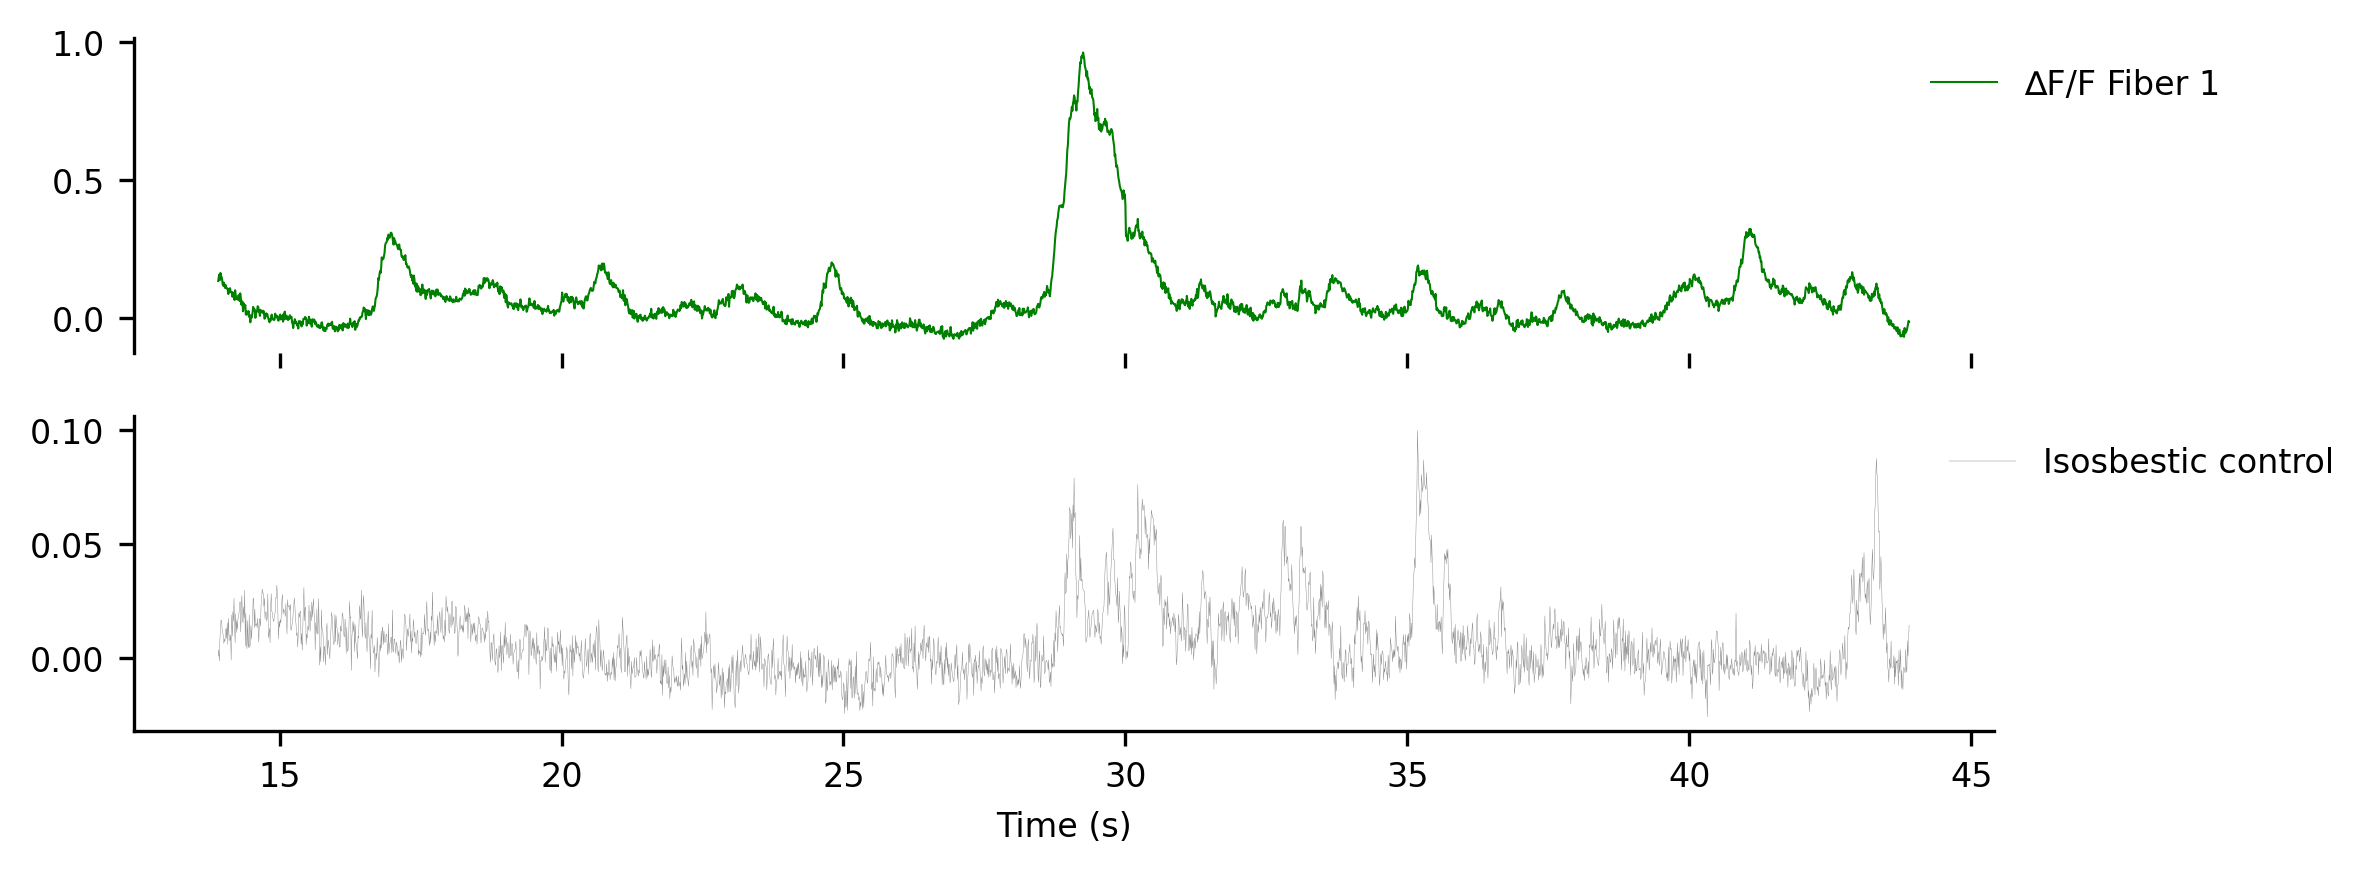

In [51]:
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = df_over_f_traces.data[0:3000, 0]
timestamps = df_over_f_traces.get_timestamps()[0:3000]

control_signal = nwbfile.processing["ophys"]["DfOverFFiberPhotometryResponseSeriesIsosbestic"]
control_data = control_signal.data[0:3000, 0]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 3), dpi=300, sharex=True)

# Plot data
ax[0].plot(timestamps, data, color="green", linewidth=0.5)

# Plot control data with offset
ax[1].plot(timestamps, control_data, color="grey", linewidth=0.1)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].legend(["∆F/F Fiber 1"], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})
ax[1].legend(["Isosbestic control"], frameon=False, bbox_to_anchor=(.96, 1), loc='upper left', prop={'size': 8})
ax[1].tick_params(axis='y', labelsize=8)
ax[0].tick_params(axis='y', labelsize=8)


plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.show()

# Access processed behavior <a id="access-behavior"></a>

This section demonstrates how to access the processed behavior data in the NWBfile.

The processed behavior data (veloctity, acceleration) is stored in "processing/behavior" which can be accessed as `nwbfile.processing["behavior"]`. Within this processing module we can access the velocity from the rotary encoder as `nwbfile.processing["behavior"]["Velocity"]`.

In [52]:
nwbfile.processing["behavior"]["Velocity"]

Velocity pynwb.base.TimeSeries at 0x13709170128
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (167634,), type "<f8">
  description: The velocity from rotary encoder converted to m/s.
  offset: 0.0
  rate: 100.0
  resolution: -1.0
  starting_time: 13.91
  starting_time_unit: seconds
  unit: m/s

## Access derived events

### Wheel events

The derived events from the wheel (accelerations, decelerations) are also stored in an `EventsTable` object using [`ndx-events`](https://github.com/rly/ndx-events) and can be accessed as `nwbfile.processing["behavior"]["WheelEvents"]`. The id and the description of the events can be accessed as `nwbfile.processing["behavior"]["WheelEventTypes"]`.


In [53]:
import pandas as pd

wheel_events = pd.merge(
    left=nwbfile.processing["behavior"]["WheelEvents"][:],
    right=nwbfile.processing["behavior"]["WheelEventTypes"][:],
    left_on="event_type",
    right_on="id",
)
wheel_events.head()

,timestamp,event_type,event_name,event_type_description
0,13.95,0,Acceleration onset,The times of the Acceleration onset event.
1,16.93,0,Acceleration onset,The times of the Acceleration onset event.
2,21.87,0,Acceleration onset,The times of the Acceleration onset event.
3,27.46,1,Deceleration onset,The times of the Deceleration onset event.
4,27.83,0,Acceleration onset,The times of the Acceleration onset event.


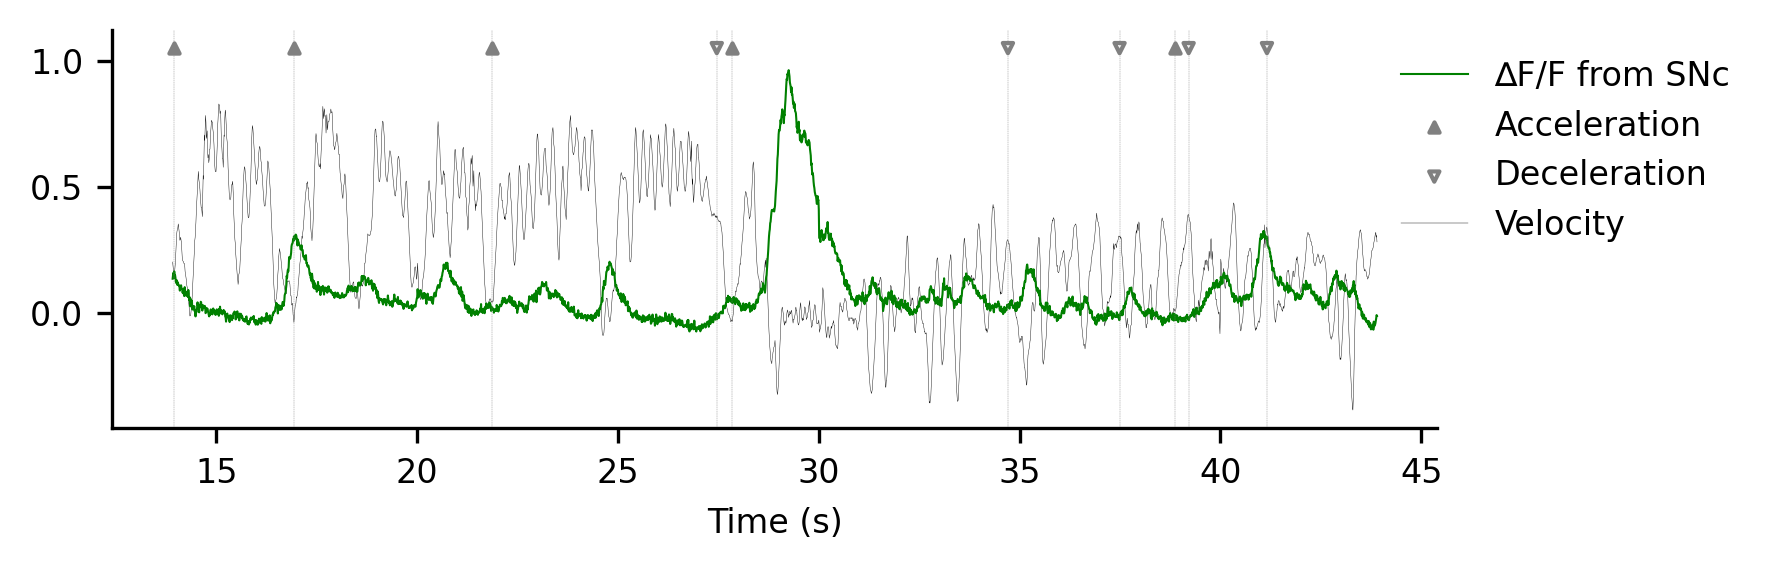

In [54]:
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = df_over_f_traces.data[:3000, 0]
timestamps = df_over_f_traces.get_timestamps()[:3000]

velocity_data = nwbfile.processing["behavior"]["Velocity"].data[:3000]

# Add events during selected time
accelerations = wheel_events[wheel_events["event_type"] == 0]
accelerations = accelerations[accelerations["timestamp"] <= 45]["timestamp"]

decelerations = wheel_events[wheel_events["event_type"] == 1]
decelerations = decelerations[decelerations["timestamp"] <= 45]["timestamp"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2), dpi=300, sharex=True)

# Plot the main data
data_handle, = ax.plot(timestamps, data, color="green", linewidth=0.5, label="∆F/F from SNc")

# Add vertical lines for events
for time in accelerations:
    ax.axvline(time, color='grey', linewidth=0.1, linestyle="--")
for time in decelerations:
    ax.axvline(time, color='grey', linewidth=0.1, linestyle="--")

# Add scatter for acceleration and deceleration
arrowhead_size = 6  # Adjust this value to change the size of the arrowheads
accel_handle = ax.scatter(accelerations, [1.05] * len(accelerations), color='grey', marker='^', s=arrowhead_size, label='▲ Acceleration')
decel_handle = ax.scatter(decelerations, [1.05] * len(decelerations), marker='v', s=arrowhead_size, facecolor='none', edgecolor='grey', label='▽ Deceleration')

# Plot the velocity data on the background
velocity_handle, = ax.plot(timestamps, velocity_data, color="black", linewidth=0.1, zorder=1, label="Velocity")

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legends
handles = [data_handle, accel_handle, decel_handle, velocity_handle]
labels = ["∆F/F from SNc", "Acceleration", "Deceleration", "Velocity"]
ax.legend(handles, labels, frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})

# Adjust tick parameters
ax.tick_params(axis='y', labelsize=8)

plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.tight_layout()
plt.show()


### Stimuli events

The times when the mouse was moving and the reward, air puff, light, and licking event times are added to `nwbfile.processing["behavior"]["Events"]`

In [27]:
events = nwbfile.processing["behavior"]["Events"][:]
events.head()

,start_time,stop_time,event_type,tags,timeseries
id,,,,,
0,13.91,201.82,MovOnOff,[],"[(55642, 751678, Velocity pynwb.base.TimeSerie..."
1,28.59,28.67,Reward,[long],"[(114365, 320, Reward pynwb.base.TimeSeries at..."
2,28.85,32.24,Licking,[],"[(115405, 13561, Licking pynwb.base.TimeSeries..."
3,32.42,32.52,Licking,[],"[(129686, 400, Licking pynwb.base.TimeSeries a..."
4,32.55,32.66,Licking,[],"[(130206, 440, Licking pynwb.base.TimeSeries a..."


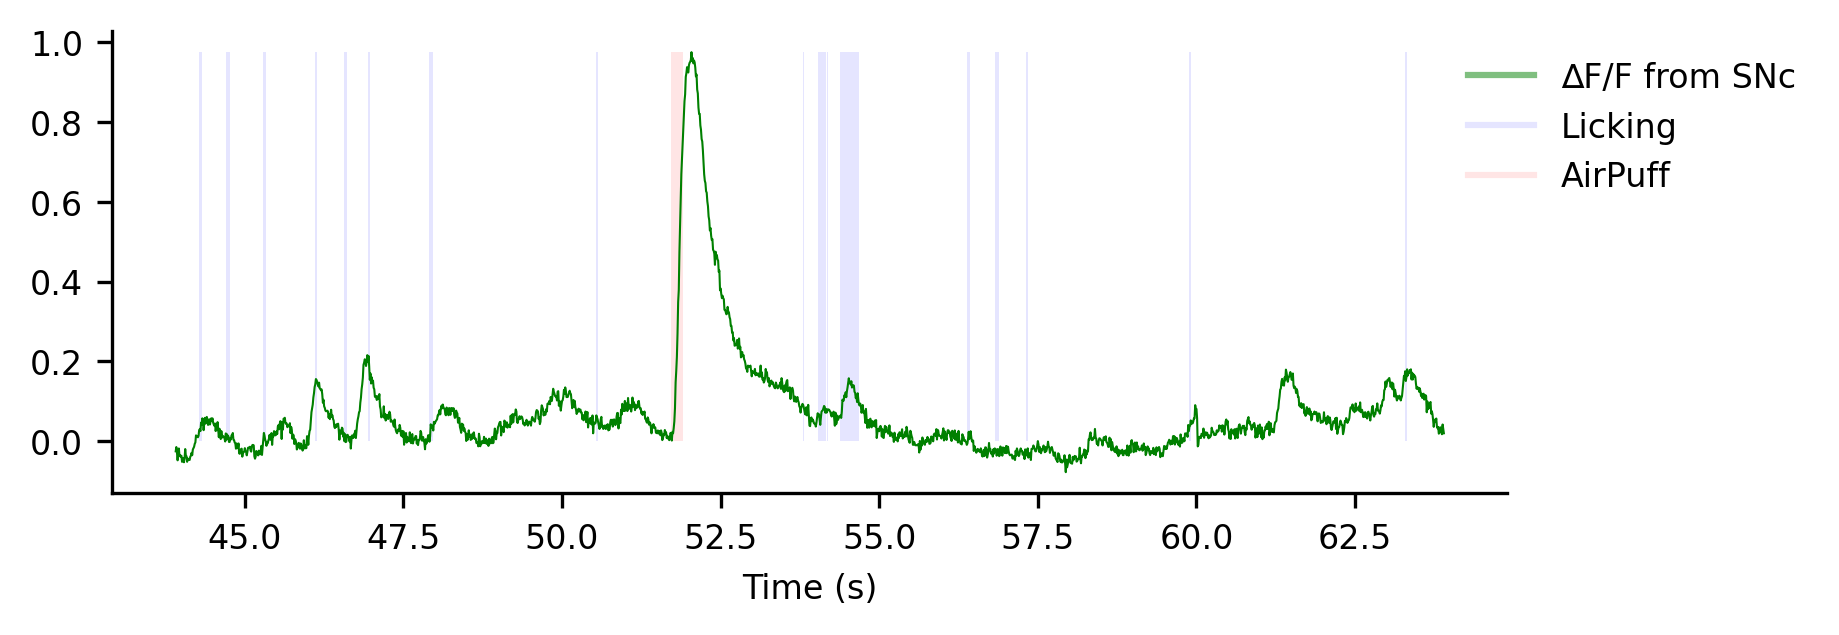

In [28]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.lines as mlines

# Prepare data for plotting
data = df_over_f_traces.data[3000:5000, 0]
timestamps = df_over_f_traces.get_timestamps()[3000:5000]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2), dpi=300, sharex=True)

# Plot the main data
ax.plot(timestamps, data, color="green", linewidth=0.5)

licking_events = events[events["event_type"] == "Licking"]
licking_events = licking_events[(licking_events["start_time"] >= timestamps[0]) & (licking_events["stop_time"] < timestamps[-1])]

airpuff_events = events[events["event_type"] == "AirPuff"]
airpuff_events = airpuff_events[(airpuff_events["start_time"] >= timestamps[0]) & (airpuff_events["stop_time"] < timestamps[-1])]

for ind, row in licking_events.iterrows():
    ax.fill_between(timestamps, max(data), where=(timestamps >= row["start_time"]) & (timestamps <= row["stop_time"]), color='blue', edgecolor='none', alpha=0.1)

for ind, row in airpuff_events.iterrows():
    ax.fill_between(timestamps, max(data), where=(timestamps >= row["start_time"]) & (timestamps <= row["stop_time"]), color='red', edgecolor='none', alpha=0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create proxy lines for legend entries with corresponding colors and transparency
green_line = mlines.Line2D([], [], color='green', label='∆F/F from SNc', alpha=0.5)
blue_line = mlines.Line2D([], [], color='blue', label='Licking', alpha=0.1)
red_line = mlines.Line2D([], [], color='red', label='AirPuff', alpha=0.1)

# Set legends with proxy lines
ax.legend(handles=[green_line, blue_line, red_line], frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 8})

ax.tick_params(axis='y', labelsize=8)

plt.xlabel('Time (s)', fontsize=8)
plt.tick_params(axis='x', labelsize=8)
plt.show()


### Fluorescence peaks

The onset times of large fluorescence peaks are also stored in an `EventsTable` object using [`ndx-events`](https://github.com/rly/ndx-events) and can be accessed as `nwbfile.analysis["PeakFluorescenceEvents"]`. The id and the description of the events can be accessed as `nwbfile.analysis["PeakFluorescenceEventTypes"]`.


In [58]:
import pandas as pd

peak_events = pd.merge(
    left=nwbfile.analysis["PeakFluorescenceEvents"][:],
    right=nwbfile.analysis["PeakFluorescenceEventTypes"][:],
    left_on="event_type",
    right_on="id",
)
peak_events.tail()

,timestamp,event_type,peak_fluorescence,event_name,event_type_description
1101,1683.64,0,0.099074,peaksG,Large transient peaks for Fiber 1 fluorescence
1102,1685.67,0,0.058068,peaksG,Large transient peaks for Fiber 1 fluorescence
1103,1685.67,1,0.058068,peaksGRun,Large transient peaks occurring during running...
1104,1689.86,0,0.113421,peaksG,Large transient peaks for Fiber 1 fluorescence
1105,1689.86,1,0.113421,peaksGRun,Large transient peaks occurring during running...


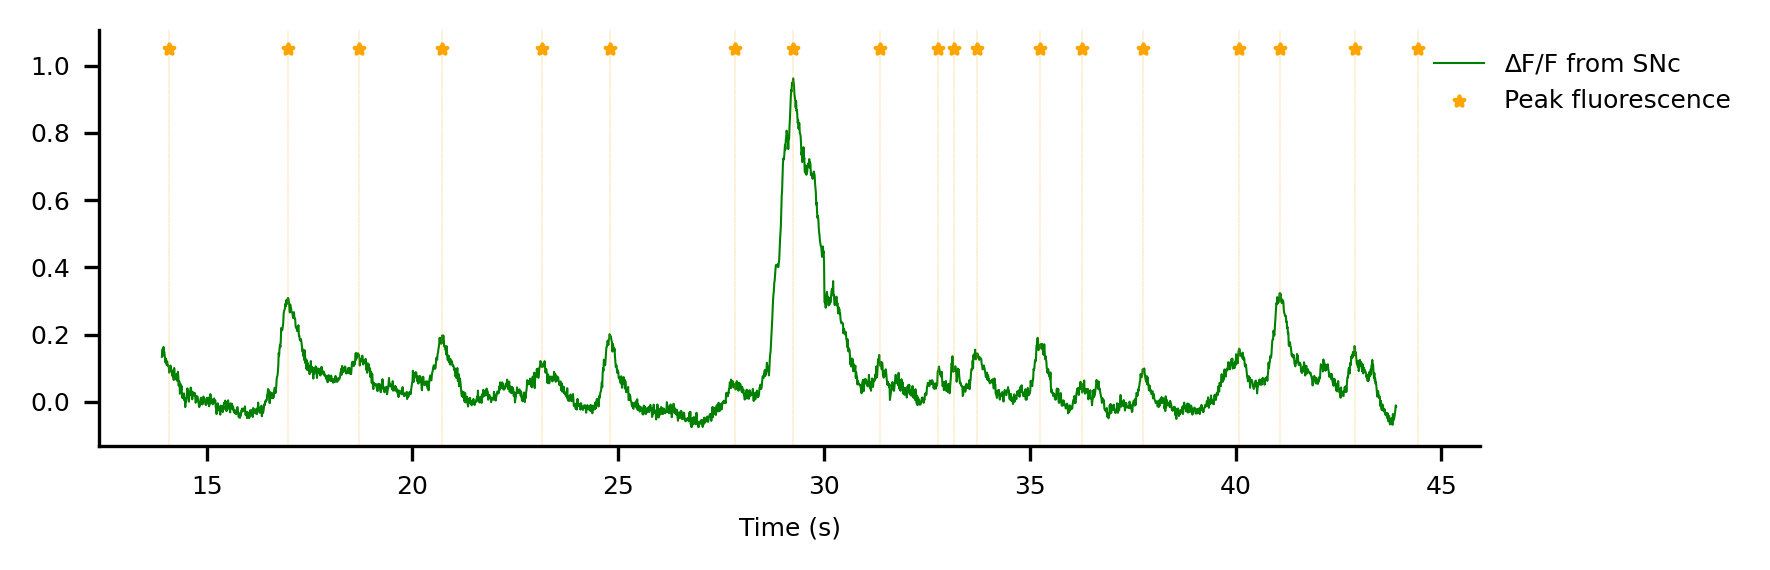

In [59]:
import pandas as pd
from matplotlib import pyplot as plt

# Prepare data for plotting
data = df_over_f_traces.data[:3000, 0]
timestamps = df_over_f_traces.get_timestamps()[:3000]

# Add events during selected time
peak_event_times = peak_events[peak_events["event_type"] == 0]
peak_event_times = peak_event_times[peak_event_times["timestamp"] <= 45]["timestamp"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2), dpi=300, sharex=True)

# Plot the main data
data_handle, = ax.plot(timestamps, data, color="green", linewidth=0.5, label="∆F/F from SNc")

# Add vertical lines for events
for time in peak_event_times:
    ax.axvline(time, color='orange', linewidth=0.1, linestyle="--")

# Add scatter for peak events
arrowhead_size = 6  # Adjust this value to change the size of the arrowheads
peak_handle = ax.scatter(peak_event_times, [1.05] * len(peak_event_times), color='orange', marker='*', s=arrowhead_size, label='Peak fluorescence')

# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legends
handles = [data_handle, peak_handle]
labels = ["∆F/F from SNc", "Peak fluorescence"]
ax.legend(handles, labels, frameon=False, bbox_to_anchor=(.95, 1), loc='upper left', prop={'size': 6})

# Adjust tick parameters
ax.tick_params(axis='y', labelsize=6)

plt.xlabel('Time (s)', fontsize=6)
plt.tick_params(axis='x', labelsize=6)
plt.tight_layout()
plt.show()


# View NWB <a id="view-nwb"></a>

This section demonstrates how to use [Neurosift](https://github.com/flatironinstitute/neurosift) to interactively visualize the data in the NWBfile.


In [61]:
from IPython.display import IFrame

url = "https://neurosift.app/?p=/nwb&url=https://api.dandiarchive.org/api/assets/9994f42b-fdbb-4938-a3a3-6add744bf169/download/&dandisetId=001038&dandisetVersion=draft&tab=neurodata-items:neurodata-item:/processing/ophys/DfOverFFiberPhotometryResponseSeries|FiberPhotometryResponseSeries@neurodata-item:/processing/ophys/DfOverFFiberPhotometryResponseSeriesIsosbestic|FiberPhotometryResponseSeries@neurodata-item:/processing/behavior/Velocity|TimeSeries"
IFrame(url, width=1200, height=1000)